In [1]:
#Importing the libraries
from nsepy import get_history as gh
import datetime as dt
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from pmdarima import auto_arima 
import warnings 
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.statespace.sarimax import SARIMAX 


In [2]:
import yfinance as yf

In [3]:

ticker = "TSLA" # Assuming 'SBIN' is a stock listed on the NSE
start = dt.datetime(2013, 1, 1)
end = dt.datetime(2019, 12, 31)

# Download the historical stock prices
data = yf.download(ticker, start=start, end=end)

C:\Users\Om Pc\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


In [6]:
#print(data)

In [4]:
#Data Preprocessing
data['Date'] = data.index
data2 = pd.DataFrame(columns = ['Date', 'Open', 'High', 'Low', 'Close'])
data2['Date'] = data['Date']
data2['Open'] = data['Open']
data2['High'] = data['High']
data2['Low'] = data['Low']
data2['Close'] = data['Close']

In [5]:
#print(data2)

In [6]:
#####################ARIMA###############################
# Ignore harmless warnings 
warnings.filterwarnings("ignore") 


In [7]:
# Ignore harmless warnings 
warnings.filterwarnings("ignore") 
# Fit auto_arima function to Stock Market Data
stepwise_fit = auto_arima(data2['Close'], start_p = 1, start_q = 1, max_p = 3, max_q = 3, m = 12, start_P = 0, seasonal = True, d = None, D = 1, trace = True, error_action ='ignore', suppress_warnings = True, stepwise = True)       

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=3.76 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=6690.612, Time=0.07 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=3128.483, Time=1.46 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=5121.637, Time=1.89 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=6706.831, Time=0.07 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=3597.328, Time=0.34 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2985.731, Time=5.91 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=14.19 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=6.18 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=6676.836, Time=3.36 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=2987.643, Time=7.13 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=2987.649, Time=7.47 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=5124.504, Time=6.37 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=2989.339, Time=15.39 sec
 ARIMA(1,0,0)(2,1,0)[12]        

In [32]:
start = dt.datetime(2020, 1, 1)
end = dt.datetime(2021, 12, 31)

# Download the historical stock prices
data6 = yf.download(ticker, start=start, end=end)

[*********************100%%**********************]  1 of 1 completed


In [55]:

# Split data into train / test sets 
train = data6.iloc[:len(data6)-60] 
test = data6.iloc[len(data6)-60:]

In [65]:
# Fit a SARIMAX
model = SARIMAX(data6['Close'],  order = (0, 1, 1),  seasonal_order =(2, 1, 1, 12)) 

In [66]:
result = model.fit() 

In [67]:
start = len(train) 
end = len(train) + len(test) - 1

In [68]:
end

497

In [69]:
  
# Predictions for one-year against the test set 
predictions = result.predict(start, end, typ = 'levels').rename("Predictions") 

In [70]:
#print(predictions)

<Axes: xlabel='Date'>

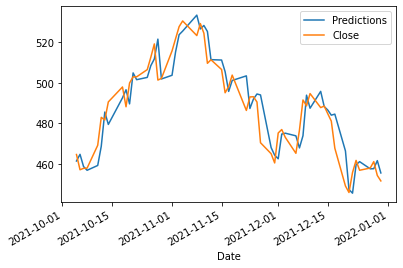

In [74]:
# plot predictions and actual values 
predictions.plot(legend = True) 
test['Close'].plot(legend = True)

In [72]:
from sklearn.metrics import mean_squared_error 
from statsmodels.tools.eval_measures import rmse 

# RMSE for ARIMA model
err_ARIMA = rmse(test["Close"], predictions) 
print('RMSE with ARIMA', err_ARIMA)


RMSE with ARIMA 8.601677609756234


In [5]:
#############LSTM########################
train_set = data2.iloc[0:1333:, 1:2].values
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train_set)
X_train = []
y_train = []
for i in range(60, 1333):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0]) 
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [6]:

#Defining the LSTM Recurrent Model
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))

C:\Users\Om Pc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:
print(len(X_train))

1273


In [8]:

#Compiling and fitting the model
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train, y_train, epochs = 40, batch_size = 16)

Epoch 1/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - loss: 0.0542
Epoch 2/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0080
Epoch 3/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0063
Epoch 4/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0062
Epoch 5/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0055
Epoch 6/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0056
Epoch 7/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0061
Epoch 8/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0050
Epoch 9/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0058
Epoch 10/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0045
Epoch 11/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0040
Epoch 12/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0041
Epoch 13/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0037
Epoch 14/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0037
Epoch 15/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0037
Epoc

In [9]:
start = dt.datetime(2020, 1, 1)
end = dt.datetime(2021, 12, 31)

# Download the historical stock prices
data6 = yf.download(ticker, start=start, end=end)

C:\Users\Om Pc\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


In [10]:

#Fetching the test data and preprocessing
testdataframe = data6
testdataframe['Date'] = testdataframe.index
testdata = pd.DataFrame(columns = ['Date', 'Open', 'High', 'Low', 'Close'])
testdata['Date'] = testdataframe['Date']
testdata['Open'] = testdataframe['Open']
testdata['High'] = testdataframe['High']
testdata['Low'] = testdataframe['Low']
testdata['Close'] = testdataframe['Close']
real_stock_price = testdata.iloc[:, 1:2].values
dataset_total = pd.concat((data2['Open'], testdata['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(testdata) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
# for i in range(60, 235):
#     X_test.append(inputs[i-60:i, 0])
for i in range(60, len(inputs)):
    sequence = inputs[i-60:i, 0]
    if len(sequence) == 60: # Ensure the sequence has 60 elements
        X_test.append(sequence)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [11]:
testdataframe[:100]

,Open,High,Low,Close,Adj Close,Volume,Date
Date,,,,,,,
2020-01-02,28.299999,28.713333,28.114000,28.684000,28.684000,142981500,2020-01-02
2020-01-03,29.366667,30.266666,29.128000,29.534000,29.534000,266677500,2020-01-03
2020-01-06,29.364668,30.104000,29.333332,30.102667,30.102667,151995000,2020-01-06
2020-01-07,30.760000,31.441999,30.224001,31.270666,31.270666,268231500,2020-01-07
2020-01-08,31.580000,33.232666,31.215334,32.809334,32.809334,467164500,2020-01-08
...,...,...,...,...,...,...,...
2020-05-19,54.344666,54.804668,53.738667,53.867332,53.867332,144547500,2020-05-19
2020-05-20,54.700001,55.066666,54.119999,54.370667,54.370667,109639500,2020-05-20
2020-05-21,54.400002,55.500000,53.066666,55.173332,55.173332,183819000,2020-05-21


In [14]:
print(len(inputs))

558


In [12]:
#Making predictions on the test data
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


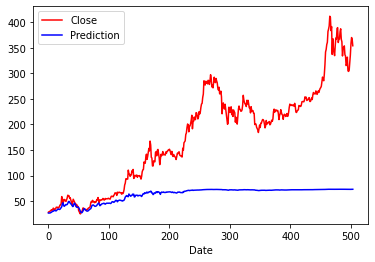

In [13]:
#Visualizing the prediction
plt.figure()
plt.plot(real_stock_price, color = 'r', label = 'Close')
plt.plot(predicted_stock_price, color = 'b', label = 'Prediction')
#plt.plot(predictions, color = 'g', label = 'ARIMA')

plt.xlabel('Date')
plt.legend()
plt.show()

In [44]:
print(dataset_total)

Date
2013-01-01    240.490005
2013-01-02    245.000000
2013-01-03    246.000000
2013-01-04    246.000000
2013-01-07    249.000000
                 ...    
2022-12-26    574.000000
2022-12-27    600.400024
2022-12-28    600.900024
2022-12-29    600.000000
2022-12-30    615.250000
Name: Open, Length: 2216, dtype: float64


In [36]:
print(len(dataset_total))

2216


In [65]:
print(len(testdata))

747


In [66]:
print(len(inputs))

807


In [14]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming 'data2' contains your entire dataset
inputs = dataset_total[:-100].values
# data7 = data2['Open']
# inputs = data7[:-200].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)

# Check if there are enough data points to create sequences
if len(inputs) < 1600:
    print("Not enough data points to create input sequences for prediction.")
else:
    X_pred = []  # Prepare list for input sequences

    # Create input sequences for prediction 
    for i in range(1700, len(inputs)):  # Extend the range by 60 steps
        start_index = max(0, i - 1700)  # Ensure start index doesn't go negative
        sequence = inputs[start_index:i, 0]
        X_pred.append(sequence)

    # Pad sequences to ensure uniform length
    X_pred = pad_sequences(X_pred, maxlen=1700, dtype='float32', padding='pre', truncating='pre')

    # Reshape for LSTM model input
    X_pred = np.reshape(X_pred, (X_pred.shape[0], -1, 1))  
    
    # Predict future values iteratively
    predicted_stock_price = []
    
    for i in range(100):
        # Predict one step ahead
        pred = regressor.predict(X_pred[i:i+1])  # Predicting only one step ahead
        predicted_stock_price.append(pred)
    
        # Concatenate pred with the last element of X_pred and reshape to match input shape
        pred = pred.reshape(1, 1, 1)
        pred = np.repeat(pred, X_pred.shape[1], axis=1)  # Repeat pred to match X_pred shape along axis 1
        X_pred = np.concatenate((X_pred, pred), axis=0)
    
    # Inverse transform to get actual values
    predicted_stock_price = sc.inverse_transform(np.array(predicted_stock_price).reshape(-1, 1))




1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [1]:
X_pred[0]

NameError: name 'X_pred' is not defined

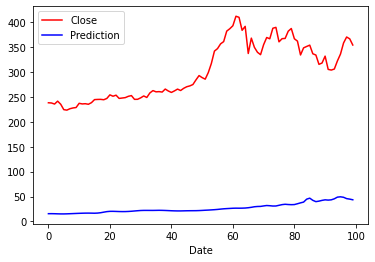

In [16]:
plt.figure()
#plt.plot(real_stock_price[:100], color = 'r', label = 'Close')
plt.plot(dataset_total[-100:].values, color = 'r', label = 'Close')
plt.plot(predicted_stock_price, color = 'b', label = 'Prediction')
#plt.plot(predictions, color = 'g', label = 'ARIMA')

plt.xlabel('Date')
plt.legend()
plt.show()

In [43]:
import numpy as np

# 'center_line' is the y-coordinate of the center line
def invert_data(predicted_stock_price, center_line):
    inverted_data = []
    for point in predicted_stock_price:
        # Calculate the distance from the center line
        distance = point - center_line
        # Calculate the mirror image
        inverted_point = center_line - distance
        # Add the inverted point to the result
        inverted_data.append(inverted_point)
    return inverted_data

center_line = np.mean(predicted_stock_price)  # Use the mean as the center line
inverted_predicted_data = invert_data(predicted_stock_price, center_line)

In [118]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Assuming 'actual_values' and 'predicted_values' are lists or arrays of actual and predicted values
actual_values = real_stock_price[:100]
predicted_values = predicted_stock_price

mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)
r2 = r2_score(actual_values, predicted_values)

# Calculate accuracy in percentage
accuracy_percentage = ((max(actual_values) - mae) / max(actual_values)) * 100

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)
print("Accuracy Percentage:", accuracy_percentage)


Mean Absolute Error (MAE): 33.86763961791992
Mean Squared Error (MSE): 2662.989165101766
Root Mean Squared Error (RMSE): 51.60415840900582
R-squared (R2) Score: 0.4351485739292006
Accuracy Percentage: [89.97850617]


In [120]:
from sklearn.metrics import mean_absolute_error

# Assuming actual_values and predicted_values are arrays or lists of actual and predicted values
actual_values = real_stock_price[:100]
predicted_values = predicted_stock_price#inverted_predicted_data

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_values, predicted_values)

# Calculate accuracy in percentage
accuracy_percentage = (1 - (mae / np.max(actual_values))) * 100

print("Accuracy:", accuracy_percentage, "%")


Accuracy: 89.97850617115164 %


In [31]:
from sklearn.metrics import mean_absolute_error

# Assuming actual_values and predicted_values are arrays or lists of actual and predicted values
actual_values = np.array([[272.75], [254.], [258.5], [251.5], [250.1000061], [258.], [256.20001221], [256.95001221], [256.45001221], [259.29998779], [256.3999939], [264.3999939], [270.3999939], [270.75], [276.], [265.79998779], [284.95001221], [283.1499939], [283.], [293.3500061], [312.3999939], [316.], [313.8999939], [318.95001221], [318.25], [316.20001221], [314.70001221], [316.04998779], [306.95001221], [312.], [324.], [325.79998779], [332.], [329.25], [331.45001221], [329.], [338.], [335.95001221], [346.8500061], [348.8500061], [343.8999939], [341.], [334.1000061], [343.], [336.70001221], [318.95001221], [317.20001221], [311.20001221], [314.], [325.20001221], [335.95001221], [333.25], [335.], [327.3500061], [330.3500061], [335.70001221], [333.20001221], [333.], [333.3999939], [337.75]])

predicted_values = np.array([[269.9116], [268.13873], [265.77136], [263.5487], [263.90884], [272.91556], [272.44824], [270.8785], [267.37146], [265.74707], [269.53326], [268.4025], [262.1271], [264.17484], [271.7662], [277.3935], [283.26492], [284.79697], [284.5202], [282.4826], [281.70078], [292.6072], [296.634], [303.71396], [315.3542], [321.99408], [321.63306], [324.9416], [326.00806], [328.367], [333.09418], [335.50134], [334.16983], [334.44516], [336.48602], [341.22516], [349.09772], [346.51706], [341.4954], [337.96985], [338.621], [343.53644], [349.1593], [353.10526], [352.3743], [349.85455], [348.6563], [347.02594], [342.50192], [339.82056], [338.1791], [338.99146], [343.40744], [345.81033], [347.9566], [334.67624], [318.38043], [320.1582], [333.10117], [342.29376]])

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_values, predicted_values)

# Calculate accuracy percentage
accuracy_percentage = (1 - (mae / np.max(actual_values))) * 100

print("Accuracy:", accuracy_percentage, "%")


Accuracy: 96.7517623307465 %


In [33]:
from sklearn.metrics import mean_absolute_error

# Convert the predicted and actual values to numpy arrays
predicted_values = inverted_predicted_data
actual_values = real_stock_price

# Calculate the absolute error
absolute_errors = np.abs(predicted_values - actual_values)

# Calculate the accuracy percentage for each predicted value
accuracies = (1 - absolute_errors / actual_values) * 100

# Print the actual values, predicted values, their difference, and accuracy
for i, (actual, predicted, diff, accuracy) in enumerate(zip(actual_values, predicted_values, absolute_errors, accuracies)):
    print(f"Value {i + 1}:")
    print(f"  Actual: {actual[0]}")
    print(f"  Predicted: {predicted[0]}")
    print(f"  Difference: {diff[0]}")
    print(f"  Accuracy: {accuracy[0]:.2f}%")



Value 1:
  Actual: 272.75
  Predicted: 269.9115905761719
  Difference: 2.838409423828125
  Accuracy: 98.96%
Value 2:
  Actual: 254.0
  Predicted: 268.13873291015625
  Difference: 14.13873291015625
  Accuracy: 94.43%
Value 3:
  Actual: 258.5
  Predicted: 265.7713623046875
  Difference: 7.2713623046875
  Accuracy: 97.19%
Value 4:
  Actual: 251.5
  Predicted: 263.5487060546875
  Difference: 12.0487060546875
  Accuracy: 95.21%
Value 5:
  Actual: 250.10000610351562
  Predicted: 263.9088439941406
  Difference: 13.808837890625
  Accuracy: 94.48%
Value 6:
  Actual: 258.0
  Predicted: 272.9155578613281
  Difference: 14.915557861328125
  Accuracy: 94.22%
Value 7:
  Actual: 256.20001220703125
  Predicted: 272.4482421875
  Difference: 16.24822998046875
  Accuracy: 93.66%
Value 8:
  Actual: 256.95001220703125
  Predicted: 270.8785095214844
  Difference: 13.928497314453125
  Accuracy: 94.58%
Value 9:
  Actual: 256.45001220703125
  Predicted: 267.3714599609375
  Difference: 10.92144775390625
  Accura

In [75]:
predicted_stock_price

array([[334.85013],
       [331.54303],
       [329.28702],
       [324.91977],
       [330.41745],
       [327.6312 ],
       [315.4172 ],
       [311.04178],
       [307.0923 ],
       [307.53818],
       [314.7706 ],
       [323.48047],
       [322.55966],
       [322.61252],
       [318.00458],
       [319.07126],
       [323.67612],
       [323.204  ],
       [322.66583],
       [322.93344],
       [325.99408],
       [324.65555],
       [324.029  ],
       [326.34857],
       [322.84375],
       [317.29913],
       [308.60162],
       [315.29904],
       [321.0898 ],
       [323.3474 ],
       [320.3685 ],
       [318.87726],
       [315.7078 ],
       [308.38538],
       [311.14218],
       [308.6022 ],
       [309.07962],
       [308.7531 ],
       [312.9793 ],
       [312.60727],
       [310.09464],
       [309.2554 ],
       [308.6691 ],
       [306.77274],
       [299.93335],
       [297.21805],
       [299.2897 ],
       [302.97653],
       [310.17484],
       [310.9288 ],


In [81]:
data6[::-100]

,Open,High,Low,Close,Adj Close,Volume,Date
Date,,,,,,,
2022-12-30,615.250000,620.549988,611.349976,613.700012,602.001587,13052895,2022-12-30
2022-08-04,543.650024,544.000000,524.200012,533.250000,523.085144,18072293,2022-08-04
2022-03-11,466.399994,474.799988,462.000000,470.350006,454.294373,22091309,2022-03-11
2021-10-18,494.000000,501.000000,491.700012,497.950012,480.952240,20084248,2021-10-18
2021-05-25,415.100006,415.500000,408.500000,412.350006,394.630798,56048127,2021-05-25
2020-12-24,265.000000,268.850006,264.649994,266.850006,255.383102,28585509,2020-12-24
2020-08-04,193.350006,193.800003,190.500000,191.600006,183.366714,43866676,2020-08-04
2020-03-06,268.000000,274.399994,253.949997,270.500000,258.876251,106043172,2020-03-06


In [84]:
from sklearn.metrics import accuracy_score

In [92]:
accuracy_score(predicted_stock_price,real_stock_price[:100])

ValueError: continuous is not supported

In [87]:
data6

,Open,High,Low,Close,Adj Close,Volume,Date
Date,,,,,,,
2020-01-01,334.700012,335.950012,332.149994,334.450012,320.078278,17379320,2020-01-01
2020-01-02,334.500000,339.850006,333.350006,339.299988,324.719818,20324236,2020-01-02
2020-01-03,337.950012,337.950012,332.000000,333.700012,319.360474,21853208,2020-01-03
2020-01-06,331.700012,331.700012,317.700012,319.000000,305.292175,35645325,2020-01-06
2020-01-07,324.450012,327.000000,315.399994,318.399994,304.717926,50966826,2020-01-07
...,...,...,...,...,...,...,...
2022-12-26,574.000000,601.700012,570.700012,597.099976,585.718018,13201587,2022-12-26
2022-12-27,600.400024,603.099976,593.299988,601.900024,590.426575,9638618,2022-12-27
2022-12-28,600.900024,607.000000,598.549988,601.049988,589.592712,7988631,2022-12-28


In [89]:
X=data6.drop('Close',axis=1)
Y=data6('Close')

TypeError: 'DataFrame' object is not callable